# Imports

In [1]:
# System
import sys

# Plotting 
import matplotlib as mpl
import matplotlib.pyplot as plt

# math and array tools 
import numpy as np
import pandas as pd
from scipy import interpolate
from itertools import permutations

# Access local directories
import os, glob

# Timing
import time as t

# Density Profiles

## Global Varibles

In [2]:
# unit conversions
hz_to_invpc = 1.029e8
s_to_pc = 9.716e-9
m_to_pc = 3.241e-17
solar_mass_to_pc = 4.8e-14
g_cm3_to_invpc2 = 7.072e8
year_to_pc = 0.3064

## Generic Density Distribution

In [3]:
scale = {'a':0.01, 'rho0':0.3}
NFWparams = {'alpha':1,'beta':3,'gamma':1}
Hernquistparams = {'alpha':1,'beta':4,'gamma':1}

In [4]:
def rho_DM_general(r, **kwargs):
    a, rho0 = kwargs['a'], kwargs['rho0']
    alpha, beta, gamma = kwargs['alpha'], kwargs['beta'], kwargs['gamma']
    # x is dimensionless
    x = r/a
    
    rho = rho0*(x**(-gamma))*(1+(x**alpha))**((gamma-beta)/alpha)
    
    # convert to pc^-2
    rho *= 1.264e-15 #[GeV/cm3 to pc-2]
    return rho

## Effective Scaling GR Density

In [5]:
scaleparameters={
    'a':0.01, #[kpc]
    'rho0':0.3, #[GeV/cm^3]
    'Mbh':1e6 #[Msol]    
}
NFWparameters={
    'alpha':0.331,
    'beta':-1.66,
    'gamma':0.32,
    'delta':-0.000282
}
Hernparameters={
    'alpha':0.335,
    'beta':-1.67,
    'gamma':0.31,
    'delta':-0.025
}
NFWfit_newton={
    'eta':2,
    'A':1.60,
    'w':2.18,
    'q':1.98
}
NFWfit_rel={
    'eta':1,
    'A':6.42,
    'w':1.82,
    'q':1.91
}
Hernfit_newton={
    'eta':2,
    'A':4.87,
    'w':2.22,
    'q':1.93
}
Hernfit_rel={
    'eta':1,
    'A':7.90,
    'w':1.83,
    'q':1.90
}

In [6]:
def rho_effective(r, **kwargs):
    # scale params
    rho0, Mbh, a = kwargs['rho0'], kwargs['Mbh'], kwargs['a']
    # profile params
    alpha, beta, gamma, delta = kwargs['alpha'], kwargs['beta'], kwargs['gamma'], kwargs['delta']
    # fit params (might need to multiple A by 1e-43Msol?)
    A, w, q, eta= kwargs['A'], kwargs['w'], kwargs['q'], kwargs['eta']
    # convert units so rho_bar has units 1/pc^2 and x_tilde is unitless
    r *= 1e3 #[kpc to pc]
    Mbh *= 4.8e-14 #[Msol to pc]
    A *= 10**-43 * (4.8e-14)**-2 #[Msol^-2 to pc^-2]
    
    x_tilde = r/Mbh
    rho_bar = A*((1-(4*eta / x_tilde))**w)*(((4.14e11)/x_tilde)**q)
    
    rho = rho_bar*(10**delta)*((rho0/0.3)**alpha)*((Mbh/1e6)**beta)*((a/20)**gamma)
    
#     return np.log10(rho*1.264e15) # convert to GeV/cm^3

    return rho

In [7]:
# rho effective takes a dictionary with scale params, profile params and fit params
rho_NFW_Newton_params = {**scaleparameters, **NFWparameters, **NFWfit_newton}

rho_effective(1, **rho_NFW_Newton_params)

29153035.421937916

# Plotting and tests

## Comparing NFW and Hernquist

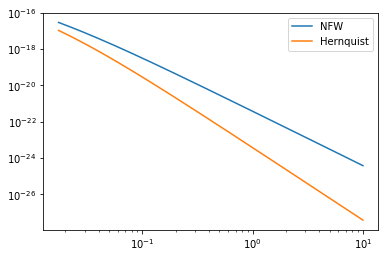

In [8]:
# r_list = np.geomspace(1e-6,100,100)
r_list = np.geomspace(1e-10,1,10000)
r_list = np.log10(r_list/(9.608e-11))

NFWparams = {**scale,**NFWparams}
Hernparams = {**scale,**Hernquistparams}

rhoNFW = np.array([[r, rho_DM_general(r, **NFWparams)] for r in r_list])
rhoHern = np.array([[r, rho_DM_general(r, **Hernparams)] for r in r_list])

plt.loglog(rhoNFW[:,0],rhoNFW[:,1], label='NFW')
plt.loglog(rhoHern[:,0],rhoHern[:,1], label='Hernquist')

plt.legend()

## Plotting Effective Scaling Density

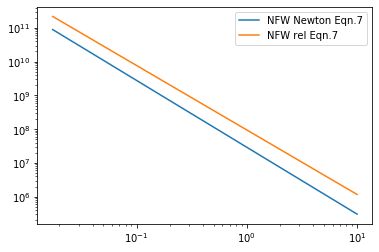

In [9]:
r_list = np.geomspace(1e-10,1,10000)
r_list = np.log10(r_list/(9.608e-11))

rho_NFW_Newton_params = {**scaleparameters, **NFWparameters, **NFWfit_newton}
rho_NFW_rel_params = {**scaleparameters, **NFWparameters, **NFWfit_rel}

rhoNFW_Newton = np.array([[r, rho_effective(r, **rho_NFW_Newton_params)] for r in r_list])
rhoNFW_rel = np.array([[r, rho_effective(r, **rho_NFW_rel_params)] for r in r_list])


plt.plot(rhoNFW_Newton[:,0],rhoNFW_Newton[:,1], label='NFW Newton Eqn.7')
plt.plot(rhoNFW_rel[:,0],rhoNFW_rel[:,1], label='NFW rel Eqn.7')
#plt.loglog(rhoNFW[:,0],rhoNFW[:,1], label='NFW Eqn.1')
plt.yscale('log')
plt.xscale('log')
plt.legend()